# AMST test YZ

Example of usage with a Jupyter Notebook.

## Alignment of dataset


In [1]:
%load_ext autoreload
%autoreload 2
from amst.amst_main import amst_align, default_amst_params

raw_folder = 'C:\\Users\\JMS\\Desktop\\AMST\\20140801_hela-wt_xy5z8nm_as_part\\raw_8bit' #  
pre_alignment_folder ='C:\\Users\\JMS\\Desktop\\AMST\\20140801_hela-wt_xy5z8nm_as_part\\tm_pre_align' # 
target_folder = 'C:\\Users\JMS\\Desktop\\AMST\\hela_res'

Running SIFT on Quadro K1100M


In [2]:
# Load the default parameters
params = default_amst_params()
params['n_workers'] = 2  # The default number of CPU cores is 8; set this to the number that is available
params['sift_devicetype'] = 'GPU'
params['coarse_alignment']= 'SIFT'
params['verbose']= True
params

{'median_radius': 7,
 'elastix_params': {'FixedInternalImagePixelType': 'float',
  'MovingInternalImagePixelType': 'float',
  'UseDirectionCosines': True,
  'Registration': 'MultiResolutionRegistration',
  'Interpolator': 'BSplineInterpolator',
  'ResampleInterpolator': 'FinalBSplineInterpolator',
  'Resampler': 'DefaultResampler',
  'FixedImagePyramid': 'FixedRecursiveImagePyramid',
  'MovingImagePyramid': 'MovingRecursiveImagePyramid',
  'Optimizer': 'AdaptiveStochasticGradientDescent',
  'Transform': 'AffineTransform',
  'Metric': 'AdvancedMattesMutualInformation',
  'AutomaticScalesEstimation': False,
  'AutomaticTransformInitialization': True,
  'HowToCombineTransforms': 'Compose',
  'NumberOfHistogramBins': 32,
  'ErodeMask': False,
  'NumberOfResolutions': 3,
  'MaximumNumberOfIterations': 200,
  'NumberOfSpatialSamples': 2048,
  'NewSamplesEveryIteration': True,
  'ImageSampler': 'RandomCoordinate',
  'BSplineInterpolationOrder': 1,
  'FinalBSplineInterpolationOrder': 3,
  'Def

In [3]:
amst_align(raw_folder=raw_folder,
    pre_alignment_folder=pre_alignment_folder,
    target_folder=target_folder,
    **params)

C:\Users\JMS\Documents\Anaconda3\envs\amst_env\lib\site-packages\amst\amst_main.py:368: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  assert im_list_raw != [], 'The raw folder does not contain *.tif files. \nEnsure the raw_folder input points to the correct location.'
C:\Users\JMS\Documents\Anaconda3\envs\amst_env\lib\site-packages\amst\amst_main.py:369: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  assert im_list_pre != [], 'The folder for the pre-alignment does not contain *.tif files. \nEnsure the pre_alignment_folder input points to the correct location.'


batch_idx = 0
Generating median smoothed templates...
Coarse alignment by translation done with SIFT.
offset = (-3.4926758, -0.7704735)
offset = (-4.1275024, 3.2596436)
Elastix align on slice_0000.tif
C:\Users\JMS\Documents\Anaconda3\envs\amst_env\lib\site-packages\amst
Found elastix version: 5.000 in 'C:\\Users\\JMS\\Documents\\Anaconda3\\envs\\amst_env\\lib\\site-packages\\amst\\elastix.exe'
Elastix align on slice_0001.tif
batch_idx = 2
Generating median smoothed templates...
Coarse alignment by translation done with SIFT.
offset = (-2.8499756, 4.0956955)
offset = (-2.4204102, 1.1482849)
Elastix align on slice_0002.tif
Elastix align on slice_0003.tif
batch_idx = 4
Generating median smoothed templates...
Coarse alignment by translation done with SIFT.
offset = (-1.2502441, 0.28424835)
offset = (-0.79447174, -0.35204315)
Elastix align on slice_0004.tif
Elastix align on slice_0005.tif
batch_idx = 6
Generating median smoothed templates...
Coarse alignment by translation done with SIFT.
o

offset = (1.3954468, -6.1899414)
offset = (1.2547607, -6.2277985)
Elastix align on slice_0068.tif
Elastix align on slice_0069.tif
batch_idx = 70
Generating median smoothed templates...
Coarse alignment by translation done with SIFT.
offset = (3.331543, -4.854126)
offset = (2.4840698, -4.7275925)
Elastix align on slice_0070.tif
Elastix align on slice_0071.tif
batch_idx = 72
Generating median smoothed templates...
Coarse alignment by translation done with SIFT.
offset = (2.2374268, -4.715637)
offset = (0.5114136, -8.750763)
Elastix align on slice_0072.tif
Elastix align on slice_0073.tif
batch_idx = 74
Generating median smoothed templates...
Coarse alignment by translation done with SIFT.
offset = (-1.1087036, -9.694618)
offset = (-1.307373, -10.763306)
Elastix align on slice_0074.tif
Elastix align on slice_0075.tif
batch_idx = 76
Generating median smoothed templates...
Coarse alignment by translation done with SIFT.
offset = (-1.8905029, -12.012901)
offset = (-2.1910706, -13.315048)
Elas

## Evaluating the alignments

In [4]:
import os
import numpy as np
import glob
from multiprocessing import Pool
from tifffile import imread, imsave
from silx.image import sift
from vigra.filters import gaussianSmoothing
import pickle
from amst.amst_main import xcorr
from matplotlib import pyplot as plt


def _evaluate_alignment_with_sift(im_0, im_1, areas, sigma=1.):
    print(im_0)

    im_0 = imread(im_0)
    im_1 = imread(im_1)

    if im_0.dtype == 'uint16':
        im_0 = (im_0 / (65536 / 255)).astype('uint8')
    if im_1.dtype == 'uint16':
        im_1 = (im_1 / (65536 / 255)).astype('uint8')

    im_0 = gaussianSmoothing(im_0, sigma)
    im_1 = gaussianSmoothing(im_1, sigma)

    offset = []

    for area in areas:

        crop_0 = im_0[area]
        crop_1 = im_1[area]

        crop_0 = gaussianSmoothing(crop_0, sigma)
        crop_1 = gaussianSmoothing(crop_1, sigma)

        try:
            # Do the alignment
            #sa = sift.LinearAlign(crop_0, devicetype='GPU')
            #aligned = sa.align(crop_1, return_all=True, shift_only=True)
           
            offs = xcorr(crop_0,crop_1)
            offset.append(offs)#aligned['offset'])
            sa = None
            aligned = None

        except TypeError:
            print('Warning: The alignment failed, appending [None, None]')
            offset.append([None, None])

    return offset


def evaluate_alignment(source_folder, areas, n_workers=16, target_filepath=None, z_range=None,
                                       plot=False, sigma=1.,
                                       func=_evaluate_alignment_with_sift):
    if z_range is None:
        imlist = np.array(sorted(glob.glob(os.path.join(source_folder, '*.tif'))))
    else:
        imlist = np.array(sorted(glob.glob(os.path.join(source_folder, '*.tif'))))[z_range]

    if n_workers == 1:
        offsets = [func(imlist[idx], imlist[idx + 1], areas, sigma=sigma) for idx in
                   range(len(imlist) - 1)]

    else:

        with Pool(processes=n_workers) as p:

            tasks = [
                p.apply_async(
                    func,
                    (imlist[idx], imlist[idx + 1], areas),
                    {'sigma': sigma}
                )
                for idx in range(len(imlist) - 1)
            ]

            offsets = [task.get() for task in tasks]

    offsets = np.array(offsets)

    if plot:
        for idx in range(offsets.shape[2]):
            offset_x = np.sqrt(np.power(offsets[:, 0, idx], 2) + np.power(offsets[:, 1, idx], 2))
            print(offset_x)
            plt.plot(offset_x)

        plt.show()

    if target_filepath is not None:

        if not os.path.exists(os.path.split(target_filepath)[0]):
            print('Making directory {}'.format(os.path.split(target_filepath)[0]))
            os.mkdir(os.path.split(target_filepath)[0])

        print('Dumping to {}'.format(target_filepath))
        with open(target_filepath, mode='wb') as f:
            pickle.dump(offsets, f)


def plot_alignment_quality(source_filepath, multiple_plots=False,
                           pixel_size=None,
                           units=None,
                           xmin=None, ymin=None, xmax=None, ymax=None,
                           mode='offsets'
                           ):
    # if pixel_size is None:
    #     pixel_size = [1, 1]
    if units is None:
        units = ['px', 'px']

    with open(source_filepath, mode='rb') as f:
        offsets = np.array(pickle.load(f))

    offsets = offsets.astype('float64')
    colorlist = [
        'xkcd:azure',
        'xkcd:goldenrod'
    ]

    if mode == 'offsets':
        ind = 2
    elif mode == 'diffs':
        ind = 1

    # FIXME something is wrong
    ind = 1

    for idx in range(offsets.shape[ind]):
        if mode == 'offsets':
            offset_x = np.sqrt(np.power(offsets[:, idx, 0], 2) + np.power(offsets[:, idx, 1], 2))
        elif mode == 'diffs':
            offset_x = offsets[:, idx]

        if multiple_plots:
            plt.figure()
            
        plt.plot(
            offset_x, color=colorlist[idx]
        )
        plt.ylabel('Displacement error [{}]'.format(units[1]))
        plt.xlabel('z [{}]'.format(units[0]))

        if ymin is not None:
            plt.ylim(ymin=ymin)
        if ymax is not None:
            plt.ylim(ymax=ymax)
        if xmin is not None:
            plt.xlim(xmin=xmin)
        if xmax is not None:
            plt.xlim(xmax=xmax)

        if pixel_size is not None:
            plt.xticks(plt.xticks()[0], plt.xticks()[0] * pixel_size[0])
            plt.yticks(plt.yticks()[0], plt.yticks()[0] * pixel_size[1])
            pass


def plot_alignment_improvement(
        source_filepath, source_filepath_ref,
        pixel_size=None,
        units=None,
        xmin=None, ymin=None, xmax=None, ymax=None,
        mode='offsets'
):

    if units is None:
        units = ['px', 'px']

    with open(source_filepath, mode='rb') as f:
        offsets = np.array(pickle.load(f))

    with open(source_filepath_ref, mode='rb') as f:
        offsets_ref = np.array(pickle.load(f))

    offsets = offsets.astype('float64')
    offsets_ref = offsets_ref.astype('float64')

    colorlist = [
        'xkcd:azure',
        'xkcd:goldenrod'
    ]

    ind = 1
    for idx in range(offsets.shape[ind]):
        if mode == 'offsets':
            offset_x = np.sqrt(np.power(offsets[:, idx, 0], 2) + np.power(offsets[:, idx, 1], 2))
            offset_x_ref = np.sqrt(np.power(offsets_ref[:, idx, 0], 2) + np.power(offsets_ref[:, idx, 1], 2))
        elif mode == 'diffs':
            raise NotImplementedError

        plt.plot(
            np.abs(offset_x - offset_x_ref), color=colorlist[idx]
        )
        plt.ylabel('Displacement error [{}]'.format(units[1]))
        plt.xlabel('z [{}]'.format(units[0]))

        if ymin is not None:
            plt.ylim(ymin=ymin)
        if ymax is not None:
            plt.ylim(ymax=ymax)
        if xmin is not None:
            plt.xlim(xmin=xmin)
        if xmax is not None:
            plt.xlim(xmax=xmax)

        if pixel_size is not None:
            plt.xticks(plt.xticks()[0],plt.xticks()[0]*pixel_size[0])
            plt.yticks(plt.yticks()[0], plt.yticks()[0]*pixel_size[1])
            pass


def statistics(source_filepath, mode='offsets'):
    with open(source_filepath, mode='rb') as f:
        offsets = np.array(pickle.load(f))

    offsets = offsets.astype('float64')
    ind = 1
    for idx in range(offsets.shape[ind]):
        if mode == 'offsets':
            offset_x = np.sqrt(np.power(offsets[:, idx, 0], 2) + np.power(offsets[:, idx, 1], 2))
        elif mode == 'diffs':
            offset_x = offsets[:, idx]
        offset_x = np.nan_to_num(offset_x)
        mean = np.mean(offset_x)
        median = np.median(offset_x)
        std = np.std(offset_x)
        mx = np.max(offset_x)
        mn = np.min(offset_x)

        print('---- AREA {} ----\n'.format(idx))
        print('Mean = {}'.format(mean))
        print('Median = {}'.format(median))
        print('Std = {}'.format(std))
        print('Max = {}'.format(mx))
        print('Min = {}\n'.format(mn))


Running SIFT on Quadro K1100M


In [5]:
areas = [
        np.s_[357:869, 2990:3504],
        np.s_[1850:2362, 2992:3504]
    ]
z_range = np.s_[16:48]

source = target_folder
target = 'C:\\Users\JMS\\Desktop\\AMST\\offsets\\offsets_SIFT.txt'

evaluate_alignment(
            source_folder=source,
            areas=areas,
            n_workers=1,
            target_filepath=target,
            z_range=z_range,
            plot=False,
            sigma=1.6,
            func=_evaluate_alignment_with_sift
        )



C:\Users\JMS\Desktop\AMST\hela_res\slice_0016.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0017.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0018.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0019.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0020.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0021.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0022.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0023.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0024.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0025.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0026.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0027.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0028.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0029.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0030.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0031.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0032.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0033.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0034.tif
C:\Users\JMS\Desktop\AMST\hela_res\slice_0035.tif


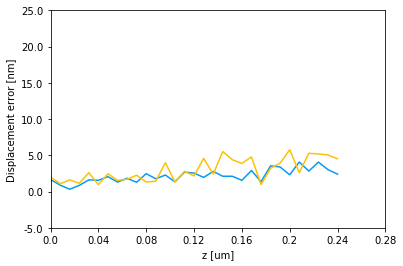

In [6]:
plot_alignment_quality(
        source_filepath=target,
        multiple_plots=False,
        ymin=-0.2, ymax=5, xmin=0, xmax=None,
        pixel_size=[0.008, 5],
        units=['um', 'nm'])


In [7]:
statistics(target)

---- AREA 0 ----

Mean = 0.4312514041635117
Median = 0.4220189569201838
Std = 0.17837881208413695
Max = 0.8149233092751735
Min = 0.06403124237432849

---- AREA 1 ----

Mean = 0.5963291136842968
Median = 0.5203844732503076
Std = 0.30796099634414004
Max = 1.1552056094046637
Min = 0.191049731745428

